# Improving a DAN trained on clean data with ASR Confidences

The following notebook reads (clean and ASR) QuizBowl data using a file called "dataset.py" and builds a Deep Averaging Network that leverages confidences to improve over the baseline.

## Dependencies - helpful Python tools, PyTorch

In [ ]:
#general python
import json
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm_notebook
import numpy as np
import string
from sklearn.metrics import accuracy_score
import time
from typing import List, Optional, Dict
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook 

#torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

#torchtext.  Dataset is a custom file for handling this data
from dataset import QuizBowl
from torchtext.data.field import Field
from torchtext.data.iterator import Iterator

In [ ]:
#legacy code to refresh dataset
import dataset
import importlib
importlib.reload(dataset)

## Model

The following section contains code that designs a Deep Averaging Network, variations thereupon in ascending order of complexity, and classes that learn confidence functions

In [ ]:
class LogRegression(nn.Module):
    def __init__(self, embedding_dim, 
                 h1_dim, text_field, answer_size):
        super(LogRegression, self).__init__()
        text_vocab = text_field.vocab
        self.text_vocab_size = len(text_vocab)
        text_pad_idx = text_vocab.stoi[text_field.pad_token]
        self.text_embeddings = nn.Embedding(self.text_vocab_size, embedding_dim, padding_idx=text_pad_idx)
        self.text_field = text_field

        mean_emb = text_vocab.vectors.mean(0)
        text_vocab.vectors[text_vocab.stoi[text_field.unk_token]] = mean_emb
        self.text_embeddings.weight.data = text_vocab.vectors#.cuda()
        self.text_embeddings.weight.requires_grad = False
        #freeze the embeddings
        
        self.dropout = nn.Dropout(p=0.2)
        self.classifier = nn.Sequential(
            nn.Linear(embedding_dim, answer_size),
            nn.BatchNorm1d(answer_size),
            nn.Dropout(.15)
        )
        
    def _pool(self, embed, lengths, batch_size):
        return embed.sum(1) / lengths.view(batch_size, -1)
    
    def forward(self, input_: Dict[str, Variable], lengths: Dict, qnums): 
        for key in lengths:
            if not isinstance(lengths[key], Variable):
                lengths[key] = Variable(lengths[key].float(), volatile=not self.training)
                
        if self.text_field is not None:
            text_input = input_['text']
            embed = self.text_embeddings(text_input)
            embed = self._pool(embed, lengths['text'].float(), text_input.size()[0])
            embed = self.dropout(embed)
            return self.classifier(embed)

Relative to the logistic regression above, the DAN adds in a hidden layer of 1000 units towards the end the network

In [21]:
class DAN(nn.Module):
    def __init__(self, embedding_dim, 
                 h1_dim, text_field, answer_size):
        super(DAN, self).__init__()
        text_vocab = text_field.vocab
        self.text_vocab_size = len(text_vocab)
        text_pad_idx = text_vocab.stoi[text_field.pad_token]
        
        #run the vocab through Glove Embeddings
        self.text_embeddings = nn.Embedding(self.text_vocab_size, embedding_dim, padding_idx=text_pad_idx)
        self.text_field = text_field
        
        #set the unknown items to the mean embedding
        mean_emb = text_vocab.vectors.mean(0)
        text_vocab.vectors[text_vocab.stoi[text_field.unk_token]] = mean_emb
        self.text_embeddings.weight.data = text_vocab.vectors#.cuda()
        #freeze the embeddings
        self.text_embeddings.weight.requires_grad = False 
        
        #layers used in the network
        self.dropout = nn.Dropout(p=0.2)
        self.nonlinear = nn.ELU()
        self.h1 = nn.Linear(embedding_dim, h1_dim)
        
        self.classifier = nn.Sequential(
            nn.Linear(h1_dim, answer_size),
            nn.BatchNorm1d(answer_size),
            nn.Dropout(.15)
        )

    def _pool(self, embed, lengths, batch_size):
        return embed.sum(1) / lengths.view(batch_size, -1)
    
    def forward(self, input_: Dict[str, Variable], lengths: Dict, qnums): 
        for key in lengths:
            if not isinstance(lengths[key], Variable):
                lengths[key] = Variable(lengths[key].float(), volatile=not self.training)
        
        #if the text exists, run it through embeddings, pool, dropout, and then run it through a hidden layer
        if self.text_field is not None:
            text_input = input_['text']
            embed = self.text_embeddings(text_input)
            embed = self._pool(embed, lengths['text'].float(), text_input.size()[0])
            embed = self.dropout(embed)
            answers = self.h1(embed)
            answers = self.nonlinear(answers)
            return F.softmax(self.classifier(answers), dim=1)

The below Confidence Learner is used to learn mappings from embeddings and confidences to a single value.  This is used in the modified DAN that follows. The simple confidence learner simply passes on the confidence.

In [ ]:
class ConfidenceLearner(nn.Module):
    def __init__(self, embeddings_dim, confidences_dim):
        super(ConfidenceLearner, self).__init__()
        self.transform = nn.Linear(embeddings_dim + confidences_dim, 1)
    
    def forward(self, embeds, confs):
        confs = confs.view(-1, 1)
        concat = torch.cat((embeds, confs), 1)
        return torch.sigmoid(self.transform(concat))

In [ ]:
class SimpleConfidenceLearner(nn.Module):
    def __init__(self, embeddings_dim, confidences_dim):
        #does nothing
        pass
    
    def forward(self, embeds, confs):
        return confs

This DAN ingests a "confidence" field from TorchText, which is a vector of confidences in range 0-1. Both init and forward are adjusted to accomodate this.

In [ ]:
class DAN_Confidences(nn.Module):
    def __init__(self, embedding_dim, 
                 h1_dim, text_field, answer_size):
        super(DAN, self).__init__()
        text_vocab = text_field.vocab
        self.text_vocab_size = len(text_vocab)
        text_pad_idx = text_vocab.stoi[text_field.pad_token]
        self.text_embeddings = nn.Embedding(self.text_vocab_size, embedding_dim, padding_idx=text_pad_idx)
        self.text_field = text_field

        mean_emb = text_vocab.vectors.mean(0)
        text_vocab.vectors[text_vocab.stoi[text_field.unk_token]] = mean_emb
        self.text_embeddings.weight.data = text_vocab.vectors#.cuda()
        self.text_embeddings.weight.requires_grad = False
        #freeze the embeddings
        
        #confidences are learned from word_embeddings and respective word_confidence
        #self.confidences = ConfidenceLearner(embedding_dim, 1)
        self.dropout = nn.Dropout(p=0.2)
        self.h1 = nn.Linear(embedding_dim, h1_dim)
        self.classifier = nn.Sequential(
            nn.Linear(h1_dim+1, answer_size),
            nn.BatchNorm1d(answer_size),
            nn.Dropout(.15)
        )
        
    def _pool(self, embed, lengths, batch_size):
        return embed.sum(1) / lengths.view(batch_size, -1)
    
    def forward(self, input_: Dict[str, Variable], lengths: Dict, qnums): 
        for key in lengths:
            if not isinstance(lengths[key], Variable):
                lengths[key] = Variable(lengths[key].float(), volatile=not self.training)
                
        if self.text_field is not None:
            text_input = input_['text']
            conf_input = input_['confidence']
            embed = self.text_embeddings(text_input)
            #confidences = self.confidences(embed)
            embed = self._pool(embed, lengths['text'].float(), text_input.size()[0])
            embed = self.dropout(embed)
            answers = self.h1(embed)
          
            answer = answers.append(conf_input.mean(dim = 0))
            #nonlinearity after linearity
            return F.softmax(self.classifier(answers), dim = 1)
        
        
        #layer.weights.data[:, -1] = pretrainedweights
        #layer.bias.data[: -1]

In [ ]:
class DAN_WeightedMean(nn.Module):
    def __init__(self, embedding_dim, 
                 h1_dim, text_field, answer_size):
        super(DAN, self).__init__()
        text_vocab = text_field.vocab
        self.text_vocab_size = len(text_vocab)
        text_pad_idx = text_vocab.stoi[text_field.pad_token]
        self.text_embeddings = nn.Embedding(self.text_vocab_size, embedding_dim, padding_idx=text_pad_idx)
        self.text_field = text_field

        mean_emb = text_vocab.vectors.mean(0)
        text_vocab.vectors[text_vocab.stoi[text_field.unk_token]] = mean_emb
        self.text_embeddings.weight.data = text_vocab.vectors#.cuda()
        self.text_embeddings.weight.requires_grad = False
        #freeze the embeddings
        
        #confidences are learned from word_embeddings and respective word_confidence
        self.confidences = ConfidenceLearner(embedding_dim, 1)
        self.dropout = nn.Dropout(p=0.2)
        self.h1 = nn.Linear(embedding_dim, h1_dim)
        self.classifier = nn.Sequential(
            nn.Linear(h1_dim+1, answer_size),
            nn.BatchNorm1d(answer_size),
            nn.Dropout(.15)
        )
        
    def _pool(self,  embed, lengths, #add confidence here batch_size):
        embed = embed * confidences
        return embed.sum(1) / confidences.sum(dim = 1)
              
        #for learning variation
              #pass in output of CONFIDENCE LEARNER into POOOl
              #dimensions will be the same, just learning new value for confidence
    
    def forward(self, input_: Dict[str, Variable], lengths: Dict, qnums): 
        for key in lengths:
            if not isinstance(lengths[key], Variable):
                lengths[key] = Variable(lengths[key].float(), volatile=not self.training)
                
        if self.text_field is not None:
            text_input = input_['text']
            conf_input = input_['confidence']
            embed = self.text_embeddings(text_input)
            #confidences = self.confidences(embed)
            embed = self._pool(embed, lengths['text'].float(), text_input.size()[0])
            embed = self.dropout(embed)
            answers = self.h1(embed)
            answer = answers.append(conf_input.mean(dim = 0))
            #nonlinearity after linearity
            return F.softmax(self.classifier(answers), dim = 1)

## Data and Training

The following code uses a custom class from dataset.py to read in the data into TorchText, which allows for easy batching in PyTorch.

In [ ]:
train_iter, val_iter, dev_iter = QuizBowl.iters(
            batch_size=512,
            lower= True,
            use_wiki=False,  #irrelevant
            n_wiki_sentences=5, #irrelevant 
            replace_title_mentions='',
            combined_ngrams=True,
            unigrams=True, 
            bigrams=False, #irrelevant 
            trigrams=False, #irrelevant 
            combined_max_vocab_size=300000,
            unigram_max_vocab_size= None, 
            bigram_max_vocab_size=50000, #irrelevant 
            trigram_max_vocab_size=50000 #irrelevant 
        )

In [3]:
import dataset_confidence
import importlib
importlib.reload(dataset_confidence)
train_iter, val_iter, dev_iter = dataset_confidence.QuizBowl.iters(
            batch_size=512,
            lower= True,
            use_wiki=False,  #irrelevant
            n_wiki_sentences=5, #irrelevant 
            replace_title_mentions='',
            combined_ngrams=True,
            unigrams=True, 
            bigrams=False, #irrelevant 
            trigrams=False, #irrelevant 
            combined_max_vocab_size=300000,
            unigram_max_vocab_size= None, 
            bigram_max_vocab_size=50000, #irrelevant 
            trigram_max_vocab_size=50000 #irrelevant 
        )

In [4]:
def run_epoch(iterator: Iterator):
        is_train = iterator.train
        batch_accuracies = []
        batch_losses = []
        epoch_start = time.time()
        for batch in iterator:
            input_dict = {}
            lengths_dict = {}
            if hasattr(batch, 'text'):
                text, lengths = batch.text
                input_dict['text'] = text
                lengths_dict['text'] = lengths
            page = batch.page
            qnums = batch.qnum#.cuda()

            if is_train:
                model.zero_grad()

            out = model(input_dict, lengths_dict, qnums)
            _, preds = torch.max(out, 1)
            accuracy = torch.mean(torch.eq(preds, page).float()).data[0]
            batch_loss = loss_function(out, page)
            if is_train:
                batch_loss.backward()
                torch.nn.utils.clip_grad_norm(model.parameters(), .25)
                optimizer.step()

            batch_accuracies.append(accuracy)
            batch_losses.append(batch_loss.data[0])

        epoch_end = time.time()

        return np.mean(batch_accuracies), np.mean(batch_losses), epoch_end - epoch_start

In [ ]:
def run_epoch_confidences(iterator: Iterator):
        is_train = iterator.train
        batch_accuracies = []
        batch_losses = []
        epoch_start = time.time()
        for batch in iterator:
            input_dict = {}
            lengths_dict = {}
            if hasattr(batch, 'text'):
                text, lengths = batch.text
                input_dict['text'] = text
                lengths_dict['text'] = lengths
            page = batch.page
            qnums = batch.qnum#.cuda()
            if hasattr(batch, 'confidence'):
                confidences = batch.confidence

            if is_train:
                model.zero_grad()

            out = model(input_dict, lengths_dict, qnums)
            _, preds = torch.max(out, 1)
            accuracy = torch.mean(torch.eq(preds, page).float()).data[0]
            batch_loss = loss_function(out, page)
            if is_train:
                batch_loss.backward()
                torch.nn.utils.clip_grad_norm(model.parameters(), .25)
                optimizer.step()

            batch_accuracies.append(accuracy)
            batch_losses.append(batch_loss.data[0])

        epoch_end = time.time()

        return np.mean(batch_accuracies), np.mean(batch_losses), epoch_end - epoch_start

## Initialization

In [32]:
#Set the dimensions and epochs for model
EMBEDDING_DIM = 300 
HIDDEN_DIM = 1000 
EPOCH = 20

#extract fields to determine vocabulary size of answers
fields: Dict[str, Field] = train_iter.dataset.fields
page_field = fields['page']
ANSWER_SIZE = len(page_field.vocab.stoi)
 
# model = DAN(EMBEDDING_DIM,
#              HIDDEN_DIM,
#              fields['text'], 
#              ANSWER_SIZE)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = 0.006)

In [ ]:
#variables to generate graphs, save best model
# train_losses, train_accuracies = [], []
# val_losses, val_accuracies = [], []
# best_accuracy = 0.

for i in tqdm_notebook(range(EPOCH)):    
    #train
    model.train()
    train_acc, train_loss, train_time = run_epoch(train_iter)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    #validate
    model.eval()
    val_acc, val_loss, val_time = run_epoch(val_iter)    
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        torch.save(model.state_dict(), './asrmodel.pth')

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

Exception in thread Thread-7:
Traceback (most recent call last):
  File "/Users/dpeskov/anaconda3/envs/ASR/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/dpeskov/anaconda3/envs/ASR/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/dpeskov/anaconda3/envs/ASR/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

/Users/dpeskov/anaconda3/envs/ASR/lib/python3.6/site-packages/ipykernel/__main__.py:6: DeprecationWarning: generator 'Iterator.__iter__' raised StopIteration


In [ ]:
#pretrainweights = model.classifier[0].weights.data
# load from existing model

#in the new model, in __init__
#layer.weights.data[:, :-1] = pretrainedweights
#layer.bias.data[:-1] #this is vector

#for average, just give it existing weights

## Results and Graphs

In [31]:
#Test on final.  Dev is taken from the ASR data, and not from Clean data, 
#so this can be dramatically lower than validation accuracy
model.eval()
test_acc, test_loss, test_time = run_epoch(dev_iter)
test_acc

/Users/dpeskov/anaconda3/envs/ASR/lib/python3.6/site-packages/ipykernel/__main__.py:6: DeprecationWarning: generator 'Iterator.__iter__' raised StopIteration


0.10405074954032897

In [ ]:
val_accuracies

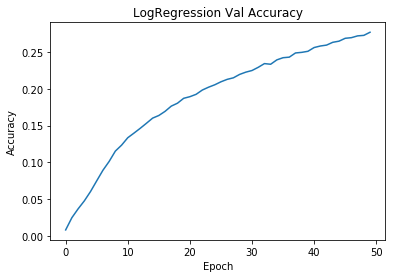

In [26]:
plt.title("LogRegression Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(train_accuracies)

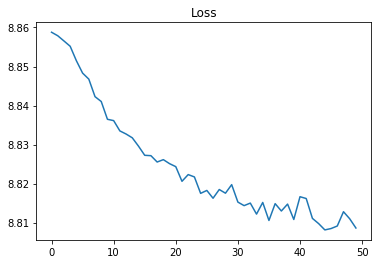

In [27]:
plt.title("Loss")
plt.plot(val_losses)